# Price Determinants in the Seattle AirBnB Market

This notebook analyses price determinants in the Seattle AirBnB market using a CRISP-DM process. For the README, data sources, and other information related to this project, please see [the corresponding github repo](https://github.com/epistemetrica/udacity-blog-post-project). 

## Business Understanding

How are prices determined for AirBnB listings in Seattle? In the most basic sense, the host sets the price for the listing based on their best guess of what renters are willing to pay for it. But how are hosts supposed to make such a determination? Intuitively, we imagine the host considers factors such as the location of the rental and the features that it offers, and thus listings in "nice" neighborhoods and with premium amenities like free parking or hot tubs will be listed at higher prices. 

This project has two parts. First, I test three questions against the available data:
- Which locations do renters prefer?
- For which features and amenities are renters willing to pay a premium? 
- Do renters place any value on the reputation of the host?

Second, I develop a pricing model to help future hosts decide where to set prices (and to help renters judge whether a fair price is being asked). 

## Data Understanding

My data come from AirBnB listings, scraped on July 18th, 2023 by Inside AirBnB (see the above-linked github page for more detailed info on the raw data). Importantly, the prices in this dataset are _advertised_ prices, not the prices at which the listings actually sell. This is a serious limitation when it comes to analyzing the business questions above. However, this is a data science portfolio project, not a formal academic analysis or industry report, so I will make the possibly-unrealistic assumption that listed prices are a decent proxy for sales prices and get on with it. 

That limitation aside, the dataset from Inside AirBnB contains a great deal of information about each listing including the listing's location, features (guest capacity, number of bedrooms and bathrooms, etc), and amenities (air conditioning, parking, wifi, etc). It also includes information about the host (whether or not they are a superhost, how many listings each host manages, etc.). 

I use two main files from Inside AirBnB: a csv file containing the above data associated with each listing, and a geojson file containing neighborhood geometries for Seattle, which coorespond to the neighbourhoods listed in the csv.

Armed with these data, we can address the above questions. 


## Data Preparation Part 1: The Basics

The data come from Inside AirBnB in csv and geojson files that are quite tidy, all things considered. However, many columns contain data in impractical data types (such as price or date info cast as strings), and data such as listing amenities are contained in long lists of strings within single cells. So, lets get to it!

First, let's install all the libraries we will use throughout this notebook , read in the data, and set a quick display option:

In [1]:
#install libraries
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import geopandas as gpd
from geopy import distance
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

#load listings data
listings_df = pd.read_csv('airbnb_data_seattle/listings.csv')

#load neighbourhood shape file 
neighbourhoods_geodf = gpd.read_file('map_data_seattle/neighbourhoods.geojson')

#remove limit on number of displayed columns
pd.set_option('display.max_columns', None)

### Recasting to the appropriate data type

Next, let's recast the various strings into the appropriate data types.

In [2]:
#recast price data from string to float

def price_str_to_float(df, *cols):
    ''' 
    INPUT:
        df - a pandas dataframe
        cols - any price columns you want to recast from string to float - expected string format is $9,999.99
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = df[col].str.replace('$','').str.replace(',','').astype('float')

price_str_to_float(listings_df, 'price')

In [3]:
#recast date data from string to pandas datetime

def date_str_to_datetime(df, *cols):
    ''' 
    INPUT:
       df - a pandas dataframe
       cols - any date columns you want to recast from string to float
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = pd.to_datetime(df[col])

date_str_to_datetime(listings_df, 'host_since', 'first_review', 'last_review')

In [4]:
#recast percents and rates from string to float

def percent_str_to_float(df, *cols):
    '''
    INPUT: 
        df - a pandas dataframe
        cols - any percent or rate columns you want to recast from string to float (e.g. '20%' will become .20)
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = df[col].str.replace('%','').astype('float')
        df[col] = df[col]/100

percent_str_to_float(listings_df, 'host_response_rate', 'host_acceptance_rate')

In [5]:
#recast columns with 't' and 'f' strings to boolean 

def tf_to_bool(df, *cols):
    '''
    INPUT:
        df - a pandas dataframe
        cols - any columns with 't' and 'f' strings you want to recast to boolean dtype
    NOTE: this change is made IN PLACE
    '''
    for col in cols:
        df[col] = df[col].map({'t': True,'f': False, np.nan: False})

tf_to_bool(listings_df, 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'license')

### Converting text descriptions into quantitative variables

The data on bathrooms for each listing is messy&mdash;the 'bathrooms' column is empty, and the 'bathrooms_text' column includes various entries such as "1 shared bath" or "Private half-bath." Since there are only 28 unique strings in the 'bathrooms_text' column, I chose a brute force mapping approach rather than building a function to interpret the various responses. 

In [6]:
#obtain unique entries in the 'bathroom_text' col
listings_df['bathrooms_text'].unique();

#map values from 'bathrooms_text' into 'bathrooms' as numerical values
listings_df['bathrooms'] = listings_df['bathrooms_text'].map({'2 baths': 2, '1 bath': 1, '1 shared bath': 1, '1 private bath': 1,
       '2.5 baths': 2.5, '3.5 baths': 3.5, '3 baths': 3, '4 baths': 4, '1.5 baths': 1.5,
       '2 shared baths': 2, '4.5 baths': 4.5, 'Half-bath': 0.5, '0 shared baths': 0,
       '3 shared baths': 3, '4 shared baths': 4, '3.5 shared baths': 3.5,
       '1.5 shared baths': 1.5, 'Private half-bath': 0.5, '6 baths': 6,
       '16 shared baths': 16, '0 baths': 0, '6.5 baths': 6.5, '5 baths': 5,
       '2.5 shared baths': 2.5, 'Shared half-bath': 0.5, '7 baths': 7, '5.5 baths': 5.5})

In [7]:
listings_df[listings_df.host_id == 31751507]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
210,15182022,https://www.airbnb.com/rooms/15182022,20230624173239,2023-06-25,city scrape,Hostel in Seattle · ★4.42 · 1 bedroom · 4 beds...,Reserve our private room at our centrally loca...,The Green Tortoise is located right in the hea...,https://a0.muscache.com/pictures/0760aeb8-d6eb...,31751507,https://www.airbnb.com/users/show/31751507,Rex,2015-04-22,"Seattle, WA",NaN,within an hour,0.99,1.0,False,https://a0.muscache.com/im/users/31751507/prof...,https://a0.muscache.com/im/users/31751507/prof...,Pike Place Market,5,6,"['email', 'phone']",True,True,"Seattle, Washington, United States",Central Business District,Downtown,47.609200,-122.338560,Private room in hostel,Private room,4,0.0,0 shared baths,1.0,4.0,"[""Washer"", ""Wifi"", ""Smoking allowed"", ""Host gr...",184.0,1,365,1.0,1.0,7.0,365.0,1.0,118.8,NaN,t,0,0,0,143,2023-06-25,27,4,0,2017-08-28,2022-10-23,4.42,4.35,4.31,4.73,4.65,4.96,4.54,NaN,True,5,0,2,3,0.38
1539,32438199,https://www.airbnb.com/rooms/32438199,20230624173239,2023-06-25,city scrape,Hostel in Seattle · ★4.72 · 1 bedroom · 8 beds...,Our centrally located Seattle hostel is famous...,The Green Tortoise is located right in the hea...,https://a0.muscache.com/pictures/b197387f-00b0...,31751507,https://www.airbnb.com/users/show/31751507,Rex,2015-04-22,"Seattle, WA",NaN,within an hour,0.99,1.0,False,https://a0.muscache.com/im/users/31751507/prof...,https://a0.muscache.com/im/users/31751507/prof...,Pike Place Market,5,6,"['email', 'phone']",True,True,"Seattle, Washington, United States",Central Business District,Downtown,47.609960,-122.339000,Shared room in hostel,Shared room,1,16.0,16 shared baths,NaN,8.0,"[""Washer"", ""First aid kit"", ""Wifi"", ""Host gree...",56.0,1,365,1.0,1.0,1.0,7.0,1.0,6.7,NaN,t,18,48,78,353,2023-06-25,497,346,14,2021-02-02,2023-06-22,4.72,4.81,4.54,4.91,4.85,4.91,4.77,NaN,True,5,0,2,3,17.06
2848,856614320500296413,https://www.airbnb.com/rooms/856614320500296413,20230624173239,2023-06-25,city scrape,Hostel in Seattle · ★4.75 · 1 bedroom · 8 beds...,Our centrally located Seattle hostel is famous...,The Green Tortoise is located right in the hea...,https://a0.muscache.com/pictures/b197387f-00b0...,31751507,https://www.airbnb.com/users/show/31751507,Rex,2015-04-22,"Seattle, WA",NaN,within an hour,0.99,1.0,False,https://a0.muscache.com/im/users/31751507/prof...,https://a0.muscache.com/im/users/31751507/prof...,Pike Place Market,5,6,"['email', 'phone']",True,True,"Seattle, Washington, United States",Central Business District,Downtown,47.609334,-122.338562,Shared room in hostel,Shared room,1,16.0,16 shared baths,NaN,8.0,"[""Washer"", ""First aid kit"", ""Wifi"", ""Host gree...",46.0,1,365,1.0,1.0,

### Converting category strings to Pandas Category dtype

In [8]:
#recast from strings to categories
listings_df[['host_response_time', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']] = listings_df[['host_response_time', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']].astype('category')

#apply order to host response time category
listings_df.host_response_time = listings_df.host_response_time.cat.set_categories(['within an hour', 'within a few hours', 'within a day', 'a few days or more'], ordered= True)

### Spurious data and empty columns

Some listings seem a bit spurious. For instance, a single host represents all the listings above $5,000 (4 of which are at the same location and listed at $10,000.00), and all their listings have extravagant prices for normal-looking listings. 

Another host, the Green Tortoise Hostel, has entered misleading information into the beds and bathrooms columns (e.g., a rental for a single twin bed is listed as having 8 beds and 16 shared bathrooms). This seems to be a ligitimate hostel, but their data is improperly entered into this database. 

The maximum number of bedrooms in the database is a whopping 13, for a listings that only allows 6 guests and boasts 3 beds. It seems likely that 13 is simply the host's typo and was supposed to be 3, but rather than make that assumption, I drop the listings. 

I drop these hosts, as well as listings with a price of $0 and any columns with completely missing data.

In [9]:
#drop spurious host id
listings_df = listings_df.drop(listings_df[listings_df.host_id == 241568755].index)

#drop Green Tortoise host
listings_df = listings_df.drop(listings_df[listings_df.host_id == 31751507].index)

#drop the host who entered 13 bedrooms but only 3 beds.
listings_df = listings_df.drop(listings_df[listings_df.id == 26756649].index)

#drop $0 listings
listings_df = listings_df.drop(listings_df[listings_df.price == 0].index)

#drop columns with missing data
listings_df.dropna(axis=1, how='all', inplace=True);

### Amenities

The amenities offered by each listing are encoded as a long string of all the diffrent amenities in the form "["feature 1", "feature 2", ...]". We will save the creation of dummy variables for later, but for now let's turn that into a proper python list. 

In [10]:
#clean up amenities column into an actual python list 
listings_df.amenities = listings_df.amenities.apply(eval)

### Natural log of prices

So that we can interpret the effects of each variable on the % change in prices (rather than the absolute number of dollars), I will go ahead and take the natural log of prices. 

In [11]:
#log prices
listings_df['ln_price'] = np.log(listings_df.price)

### Distance to City Center

A classic metric in the economic evaluation of property values is the property's distance from the city center. Let's look first at the geometric distances between each listing and the city center. Since our geographic area of interest is small, the cartesian distance between coordinates would be accurate enough. However, I'm a huge nerd so I'm going to use the geodesic distance based on the WGS-84 ellipoid.

In [12]:
#seattle city center, obtained from google
city_center = (47.6050,-122.3344) 

#GeoPy distance function expects a lat/long tuple, so:
listings_df['coordinates'] = tuple(zip(listings_df.latitude, listings_df.longitude))

#compute distance for each listing
listings_df['distance_from_cc'] = listings_df.apply(lambda row: distance.distance(row.coordinates, city_center).miles, axis=1)

### Drop unused columns and rename as appropriate

The dataframe includes a number of columns that are not useful to this analysis. Either they are repetitive in one way or another, such as the 'bathrooms' and 'bathrooms_text' columns mentioned above, or they are unrelated to the question of price determinants (e.g., since we are using listed prices as a proxy for sales prices, we are not concerned with whether the listing is available). 

In [13]:
#drop unused columns
listings_df = listings_df.drop(columns=['name', 'description', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url',
                                        'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                                        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'neighbourhood',
                                        'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
                                        'minimum_maximum_nights', 'maximum_maximum_nights', 'has_availability', 'availability_30',
                                        'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 
                                        'number_of_reviews_ltm', 'number_of_reviews_l30d', 'last_review', 'license', 
                                        'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                                        'calculated_host_listings_count_shared_rooms', 'bathrooms_text', 'host_neighbourhood', 'latitude',
                                        'longitude', 'neighborhood_overview'])

In [14]:
#rename 
listings_df['neighbourhood'] = listings_df['neighbourhood_cleansed']
listings_df['neighbourhood_group'] = listings_df['neighbourhood_group_cleansed']
listings_df['min_nights'] = listings_df['minimum_nights_avg_ntm']
listings_df['max_nights'] = listings_df['maximum_nights_avg_ntm']
listings_df['host_listings_count'] = listings_df['calculated_host_listings_count']

#drop
listings_df = listings_df.drop(columns=['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calculated_host_listings_count'])

### Reorder columns

Finally, I re-order the columns for the sake of sanity

In [15]:
#reorder columns (as copy to avoid view/copy confusion)
listings_df = listings_df[['id', 'price', 'ln_price', 'coordinates', 'distance_from_cc', 
                           'neighbourhood', 'neighbourhood_group', 'property_type', 'room_type', 'accommodates', 'bathrooms', 
                           'bedrooms', 'beds', 'amenities', 'number_of_reviews', 'first_review', 'review_scores_rating',
                           'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                           'review_scores_location', 'review_scores_value', 'reviews_per_month', 'min_nights', 'max_nights',
                           'instant_bookable', 'host_id', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                           'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_listings_count']].copy()

## Data Preparation Part 2: Dummy Variables

Now that the basic data set is all clean and tidy, it's time to create dummy variables. The number of possible dummy variables is quite large, so I will only create the variables that will be useful later on. 

In the modeling section, I run a model from a popular paper by Gibbs and collaborators, who include whether a listing is an independent property or part of a multi-unit building. The authors do not specify exactly how they determined this, and my dataset contains 52 unique descriptions of property type such as "Entire rental unit", "Private room in bed and breakfast", "Tiny home", etc. So I will play fast-and-loose here and categorize property types as "independent" based on my best guess from the property type description.

In [16]:
#define independent property types
independent_types = ['Entire home', 'Entire townhouse', 'Entire guesthouse', 'Entire Cottage', 'Entire bungalow', 'Entire vacation home',
                     'Tiny home', 'Entire cabin', 'Entire villa', 'Boat', 'Houseboat', 'Camper/RV', 'Entire place', 'Bus', 'Tent', 
                     'Casa particular', 'Farm stay']

listings_df['independent_property'] = listings_df.apply(lambda row: True if row.property_type in independent_types else False, axis=1)

As mentioned above, the amenities data is contained in long lists in each cell of the column, so for each variable (free parking, wifi, etc) I isolate the strings that define the variable then create dummies based on whether or not the listing includes one of the relevant strings. 

Amenities selected for analyses correspond to the major amenities by which potential renters can filter listings on AirBnB's platform and/or the amenities choses by Gibbs and collaborators. 

In [17]:
#define function to find any member of a string in another string
def string_list_search(strings_to_find, strings_to_search):
    ''' 
    Input:
        strings_to_find - a list of strings you want to find
        strings_to_search - a list of strings where you may find the strings you want to find
    Output:
        boolean returning true if any of the strings in strings_to_find occur in strings_to_search
    '''
    if any(string in strings_to_find for string in strings_to_search):
        return True
    return False

In [18]:
#dummy variable creation function from the course lessons
def create_dummy_df(df, *cat_cols, dummy_na):
    ''' 
    Input: 
    df - a pandas dataframe with categorical variables
    cat_cols - strings corresponding to the categorical column names
    dummy_na - whether or not you want dummy_na category for your variable, default = True

    Output:
    df - a new dataframe with the following characteristics:
        - contains all the columns not specified under cat_cols
        - removes all the original columsn specified under cat_cols
        - uses a prefix for the new columns corresponding to the original column name
    
    NOTE: this changes is made IN PLACE
    '''
    for col in cat_cols:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', dummy_na=dummy_na)], axis=1)
    return df 

In [19]:
#get list of unique amenities strings
unique_amenities = [str(i) for i in list(listings_df.amenities.explode().unique())]

In [20]:
#get gym list
gym_list = list(filter(lambda x: 'gym'.lower() in x.lower(), unique_amenities))

#create gym dummy variable
listings_df['gym'] = listings_df.apply(lambda row: string_list_search(gym_list, row.amenities), axis= 1)

In [21]:
#get list of amenities including pool (trying to avoid including Whirlpool appliances, etc.)
pool_list = list(filter(lambda x: ' pool'.lower() in x.lower(), unique_amenities))
Pool_list = list(filter(lambda x: 'Pool' in x, unique_amenities))
pool_list = Pool_list + pool_list
pool_list.remove('WhitePool refrigerator')

#create dummy variable for pool 
listings_df['pool'] = listings_df.apply(lambda row: string_list_search(pool_list, row.amenities), axis= 1)


In [22]:
#get parking list
parking_amenities = list(filter(lambda x: 'parking'.lower() in x.lower(), unique_amenities))

#inspect strings that mention parking
parking_amenities;

#create free parking strings list
free_parking_strings = ['Free driveway parking on premises – 2 spaces', 'Free street parking', 'Free parking on premises',
                        'Free driveway parking on premises – 1 space', 'Free driveway parking on premises', 'Free parking on premises – 1 space',
                        'Free parking garage on premises – 1 space', 'Free driveway parking on premises – 3 spaces', 'Free parking on premises – 2 spaces',
                        'Free driveway parking on premises – 11 spaces', 'Free parking on premises – 3 spaces', 'Free parking garage on premises – 2 spaces',
                        'Free driveway parking on premises – 4 spaces', 'Free parking garage on premises', 'Free parking garage on premises – 11 spaces', 
                        'Free parking on premises – 4 spaces', 'Free parking garage on premises – 4 spaces', 'Free driveway parking on premises – 7 spaces']

#create free parking dummy variable
listings_df['free_parking'] = listings_df.apply(lambda row: string_list_search(free_parking_strings, row.amenities), axis= 1)

In [23]:
#get beachfront/waterfront list
beachfront_list = list(filter(lambda x: 'beach'.lower() in x.lower(), unique_amenities))
waterfront_list = list(filter(lambda x: 'waterfront'.lower() in x.lower(), unique_amenities))
waterfront_list = waterfront_list + beachfront_list

#finalize list
waterfront_list = ['Waterfront', 'Public or shared beach access – Beachfront', 'Public or shared beach access', 
                   'Beach access – Beachfront','Beach access', 'Beach view', 'Private beach access', 'Private beach access – Beachfront']
#create waterfront dummy variable
listings_df['waterfront'] = listings_df.apply(lambda row: string_list_search(waterfront_list, row.amenities), axis= 1)

In [24]:
#get hot tub list
hottub_list = list(filter(lambda x: 'hot tub'.lower() in x.lower(), unique_amenities))

#create hot tub dummy variable
listings_df['hot_tub'] = listings_df.apply(lambda row: string_list_search(hottub_list, row.amenities), axis= 1)

In [25]:
#get ac list
ac_list = list(filter(lambda x: ' ac '.lower() in x.lower(), unique_amenities))
aircon_list = list(filter(lambda x: 'air conditioning'.lower() in x.lower(), unique_amenities))
ac_list = ac_list + aircon_list

#create AC dummy
listings_df['ac'] = listings_df.apply(lambda row: string_list_search(ac_list, row.amenities), axis= 1)

In [26]:
#get workspace list
workspace_list = list(filter(lambda x: 'workspace'.lower() in x.lower(), unique_amenities))

#create dummy
listings_df['workspace'] = listings_df.apply(lambda row: string_list_search(workspace_list, row.amenities), axis= 1)

In [27]:
#get EV Charger list
ev_list = list(filter(lambda x: 'charger'.lower() in x.lower(), unique_amenities))

#create dummy
listings_df['ev_charger'] = listings_df.apply(lambda row: string_list_search(ev_list, row.amenities), axis= 1)

In [28]:
#create dummy variables for entire place, private room, and shared room
listings_df = create_dummy_df(listings_df, 'room_type', dummy_na= False);

#create professional host dummy variable 
listings_df['professional_host'] = listings_df.apply(lambda row: True if row.host_listings_count >= 2 else False, axis=1)

#create neighbourhood dummy variable (reference dummy = Other Neighbourhoods)
listings_df = pd.concat([listings_df, pd.get_dummies(listings_df['neighbourhood_group'])], axis=1)

In [29]:
#drop property_type column since all it is fully encoded as dummies
listings_df = listings_df.drop(columns=['property_type'])

As a final step in creating dummy variables, I convert the boolean data types to integer 1/0 types. This will ease analyses later on. 

In [31]:
listings_df = listings_df.apply(lambda column: column.replace({True: 1, False: 0}))

## Data Preparation Part 3: Missing Data

There are two major areas of missing data that we need to address: listings with no entries for number of bedrooms or beds, and listings with no reviews. 

### Listings with no bedrooms or beds data

~24% of the listings in our dataset have missing values in the bedrooms column. Given that listings with missing bedroom data range from $13 to $900 per night, have anywhere from 1 to 8 beds, and accomodate anywhere from 1 to 14 guests, there doesn't seem to be much sense in dropping these listings or assigning them all a given number of beds. After all, assinging nearly a quarter of the observations a centrality metric would dramatically reduce our ability to explain listing prices due to changes in number of bedrooms. A similar situation applies to listings with missing data for beds, although these are a much smaller proportion of the dataset. 

For these reasons, I deploy a KNN algorithm to impute the number of bedrooms and the number of beds for listings with missing data. Special thanks to Bex T. for their [excellent tutorial](https://towardsdatascience.com/advanced-missing-data-imputation-methods-with-sklearn-d9875cbcc6eb) on KNN imputation of missing data. 

In [32]:
#restrict df to relevant quantitative variables only
df = listings_df.drop(columns= ['id', 'price', 'neighbourhood', 'neighbourhood_group', 'coordinates', 'amenities','host_since', 'first_review', 'host_response_time'])

#define imputation 
knn_imp = KNNImputer()

#impute missing values
df.loc[:,:] = knn_imp.fit_transform(df).astype('int')

#add missing bedrooms data back into listings df
listings_df[['bedrooms','beds']] = df[['bedrooms','beds']]


### Listings with no reviews

Recall that this is _advertising_ data, and the only indication we have in the data set for whether or not the listing has ever been rented is the presense of reviews. Since reviews can only come from actual renters, I will assume that whether or not a listing has any reviews is a decent proxy for whether or not the listing has ever been rented, and thus listings with no reviews are assumed to have never been rented. 

Since this analysis depends on using asking prices as a proxy for sale prices, it would not make sense to include listings that have not sold. To that end, listings with no reviews are dropped from the main dataset (but I save them for later!)

In [33]:
#save listings with no reviews
listings_noreviews_df = listings_df[listings_df.review_scores_rating.isna()]

#drop listings with no reviews from main dataframe
listings_df = listings_df.dropna(subset=['review_scores_rating'])

## Data Preparation Part 4: map geometries 

I want to look at some of this data as a map, so I will pull in the geojson file from Inside AirBnB. The file contains geometries for the 91 individual neighborhoods of Seattle, so I will also need to merge them into their corresponding groups. 

In [34]:
#merge polygons by neighbourhood group
neighbourhood_groups_geodf = neighbourhoods_geodf.dissolve(by='neighbourhood_group', as_index= False)

#drop extraneous neighbourhood column 
neighbourhood_groups_geodf = neighbourhood_groups_geodf.drop('neighbourhood', axis=1)

## Data Modeling Part 1: exploratory and visual analyses

Boring part done, now for the fun! 

### Which locations do renters prefer?

It's against the law, I think, to talk about real estate without saying location location location. So, which locations in Seattle are more valuable? Let's take a simple look at median prices by neighborhood. 

As a quick side note: housing market analyses typically speak in terms of the _median_ rather than the mean/average since housing markets are characterized by a small number of extremly expensive properties, which have an outsized influence on the mean. 


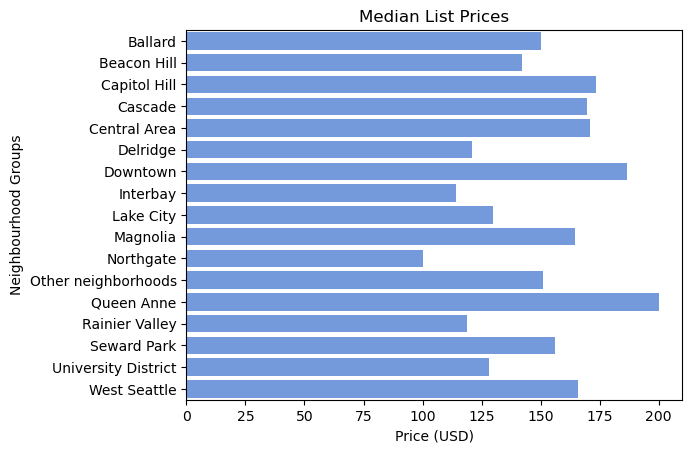

In [35]:
#obtain median values by neighborhood 
neighbourhood_group_prices = listings_df[['neighbourhood_group','price']].groupby('neighbourhood_group', as_index=False).median()

#plot in seaborn
p = sns.barplot(y= 'neighbourhood_group', x= 'price', data=neighbourhood_group_prices, color='cornflowerblue')
p.set(ylabel='Neighbourhood Groups', xlabel='Price (USD)', title= 'Median List Prices');

It may also be helpful to see this data displayed on a map. To do this, I'll pull in the data for neighbourhood geometries and make a choropleth map based on median values. 

In [36]:
#initialize map
neighbourhood_groups_choropleth = folium.Map(location= [47.6062, -122.3321], zoom_start=11)

#construct choropleth
cp = folium.Choropleth(geo_data= neighbourhood_groups_geodf, data= neighbourhood_group_prices, columns= ["neighbourhood_group", "price"],
                  key_on= "feature.properties.neighbourhood_group", nan_fill_opacity= 0,
                  ).add_to(neighbourhood_groups_choropleth)

#add interactive labels
folium.GeoJsonTooltip(['neighbourhood_group']).add_to(cp.geojson)

display(neighbourhood_groups_choropleth)

In this map, it seems like listings are more expensive in neighborhoods closer to downtown. Perhaps the distance from the city center is also important? Let's drill down to the neighborhood level and see if the pattern holds.

In [37]:
#group by neighbourhood and compute median prices
neighbourhood_prices = listings_df[['neighbourhood','price']].groupby('neighbourhood', as_index=False).median()

#initialize map
neighbourhoods_choropleth = folium.Map(location= [47.6062, -122.3321], zoom_start=11)

#construct choropleth
cp = folium.Choropleth(geo_data= neighbourhoods_geodf, data= neighbourhood_prices, columns= ["neighbourhood", "price"],
                  key_on= "feature.properties.neighbourhood", nan_fill_opacity= 0,
                  ).add_to(neighbourhoods_choropleth)

#add interative labels
folium.GeoJsonTooltip(['neighbourhood']).add_to(cp.geojson)

display(neighbourhoods_choropleth)

Yeah, not so much. 

And why is the Industrial District suddenly the most expensive neighborhood? As it turns out, there are only two listings in the Industrial District neighbourhood, and one of them is an art gallery and spa you can rent for $1,000 per night. So, the individual neighbourhoods are too granular, and we need the aggregation of the neighbourhood groups in order for the choropleth to make sense. 

In order to inspect the value that renters place on the distance from downtown, we can look at the correlation between prices and the distance from the city center. Since our geographic area of interest is small, the cartesian distance between coordinates would be accurate enough. However, I'm a huge nerd so I'm going to use the geodesic distance based on the WGS-84 ellipoid. 

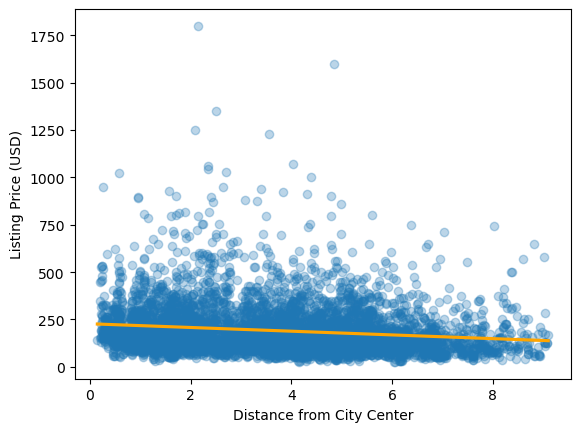

In [38]:
p = sns.regplot(data= listings_df, x= 'distance_from_cc', y= 'price',
            scatter_kws= {'alpha': 0.3},
            line_kws= {'color': 'orange'});
p.set(xlabel= 'Distance from City Center', ylabel= 'Listing Price (USD)');

There appears to be a slight correlation based on the scatter plot and regression line, but it may be easier to see with logged prices:

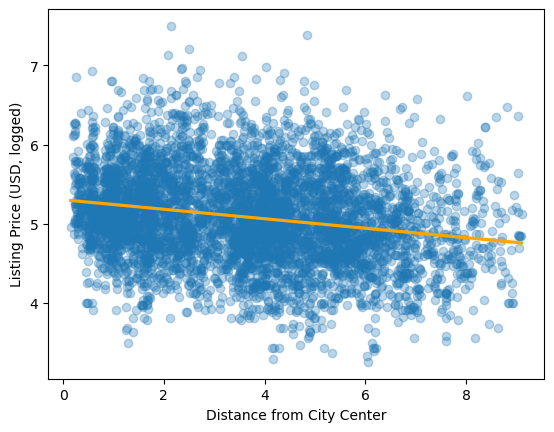

In [39]:
p = sns.regplot(data= listings_df, x= 'distance_from_cc', y= 'ln_price', 
            scatter_kws= {'alpha': 0.3},
            line_kws= {'color': 'orange'});
p.set(xlabel= 'Distance from City Center', ylabel= 'Listing Price (USD, logged)');

In [40]:
scipy.stats.pearsonr(x= listings_df.distance_from_cc, y= listings_df.ln_price)

PearsonRResult(statistic=-0.21361488501170317, pvalue=2.7635043657014145e-58)

The scatterplot of logged prices seems a little more obvious, but visual relationships can be deceiving. Computing the Pearson R is more robust, and reveals a significant reduction in prices as the distance to the city center increases: for every additional mile away from the city center, listing prices drop ~22% with 1.5 chances in _10 octodecillion_ that there is no correlation. 

This may, of course, be more incidental than causal. Perhaps the neighborhood is what's important, and the neighborhoods that are closer to the city center just happen to be more desirable independent of their distance to the center of town. Or, perhaps the particular listings in downtown are actually just nicer places to stay (more desirable features, better reviews, etc) and would command the same high prices even if they were located further away. 

To twease out these effects, we must turn to the favorite tool of economics: multivariate regression. But before we get there, let's put location aside and take a look at which amenities are valued by renters. One way to inspect the relationship between amenities and prices is to look at the median price of all listings that offer that amenity:

In [41]:
#make list of amenities dummy variables
amenities = ['gym', 'pool', 'free_parking', 'waterfront', 'hot_tub', 'ac', 'workspace', 'ev_charger']
median_prices = []

#compute median prices for each amenity
for amenity in amenities:
    median_prices.append(listings_df.price[listings_df[amenity] == 1].median())

#buils amenities and prices data frame
amenities_df = pd.DataFrame({'amenity': amenities, 'median_price': median_prices})

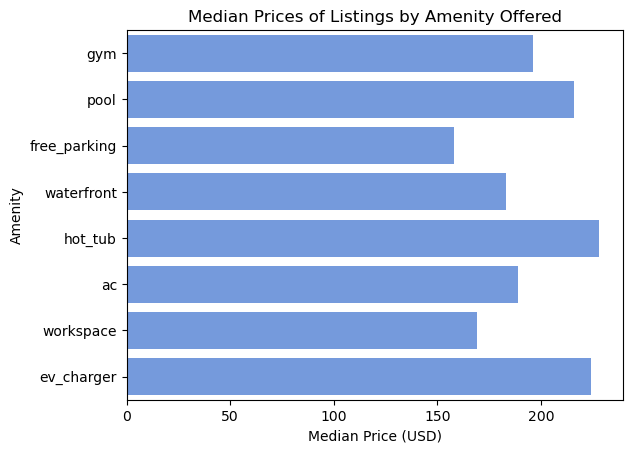

In [42]:
#graph
p = sns.barplot(data=amenities_df, x= 'median_price', y= 'amenity', color='cornflowerblue');
p.set(ylabel='Amenity', xlabel='Median Price (USD)', title= 'Median Prices of Listings by Amenity Offered');

So we can see that listings that offer hot tubs command higher prices than those that offer free parking. But the usefulness of this info is limited, since many listings offer both free parking and hot tubs and thus would be included in the calculation of median prices for both categories. 

We can also take a look at the relationship between listing prices and quantitative features such as number of bedrooms and bathrooms: 

In [43]:
df = listings_df[['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds']]


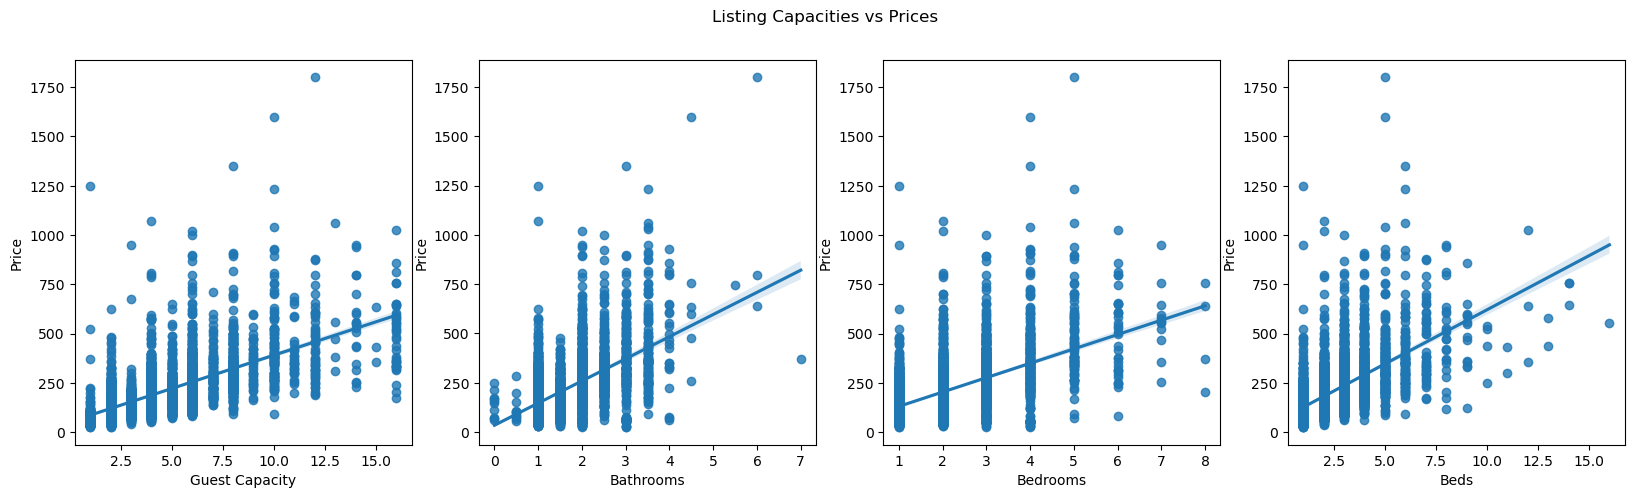

In [44]:
#initiate subplots
fig, axes = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Listing Capacities vs Prices')

#plot capacity vs price
sns.regplot(ax=axes[0], x=df.accommodates, y=df.price)
axes[0].set(xlabel='Guest Capacity', ylabel="Price")

sns.regplot(ax=axes[1], x=df.bathrooms, y=df.price)
axes[1].set(xlabel= 'Bathrooms', ylabel='Price')

sns.regplot(ax=axes[2], x=df.bedrooms, y=df.price)
axes[2].set(xlabel='Bedrooms', ylabel='Price')

sns.regplot(ax=axes[3], x=df.beds, y=df.price)
axes[3].set(xlabel='Beds', ylabel='Price');

It seems there's a stronger relationship (i.e., a steeper regression line) between price and the number of bathrooms or the number of beds than there is between price and the total guest capacity or number of bedrooms. This might indicate that renters care more about beds and bathrooms than they do about bedrooms and total capacity. 

However, it's important to remember that each of these plots is independent of the others: i.e., the fourth plot shows _simply_ the correlation between number of beds and price. It does not account for the fact that listings with a higher number of beds almost certainly have a greater number of bedrooms as well, and both affects may influence price. 

In order to inspect each effect seperately, we need to move on to a multivariate regression model.

## Data Modeling Part 2: What _really_ influences prices?

A standard way to evaluate housing prices is to assume that renters do not value the listing _itself_ but rather are willing to pay for the property in order to utilize the various characteristics of the listing that cannot be purchased seperately. In other words, buyers place value on the location, the number of bedrooms and bathrooms, whether there is parking available, whether the host is reliable, etc. etc., and the price buyers are willing to pay for the listing is simply the sum of the prices they are willing to pay for the individual characteristics. 

More precisely, we would say the price of listing $n$ is equal to the sum of the values of the $K$ characteristics of that listing. 

$$ Price_n = \sum_{k=1}^{K} (\beta_{k} \times Characteristic_{n,k}) $$

where $\beta_{k}$ is the _"hedonic price"_ of characteristic $k$ and $Characteristic_{n,k}$ refers to the quantity of characteristic $k$ present in listing $n$ (or the boolean presense of the characteristic in the case of qualitative characteristics).

This is called the [_hedonic pricing model_](https://link.springer.com/referenceworkentry/10.1007/978-94-007-0753-5_1279), and it has been [widely applied](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=hedonic+model+airbnb&btnG=&oq=hedonic+model+) to analyze AirBnB markets.

### Applying a popular hedonic model

[One of the most-cited papers](https://www.researchgate.net/profile/Daniel-Guttentag/publication/316056041_Pricing_in_the_sharing_economy_a_hedonic_pricing_model_applied_to_Airbnb_listings/links/5ab2bf72aca272171001bfc7/Pricing-in-the-sharing-economy-a-hedonic-pricing-model-applied-to-Airbnb-listings.pdf) applying hedonic models to AirBnB prices is from Chris Gibbs and collaborators, published in the Journal of Travel and Tourism Marketing in 2017. Their model uses data similar in structure to our data set, so we'll begin my estimating their model on our data. 

Gibbs and collaborators estimated listing prices as a function of the following variables:
- whether or not the listing is a private room rather than an entire place 
- whether or not the listing is a shared room rather than an entire place
- whether or not the listing is an independant property rather than a multi-unit dwelling
- guest capacity
- number of bedrooms
- number of bathrooms
- distance to the local City Hall
- whether or not free parking is available
- whether or not a pool is available  
- whether or not a gym is available
- whether or not the listing can be instantly booked
- the number of pictures posted on the listing
- the number of reviews
- the average review rating 
- whether or not the host is a professional (with at least two listings)
- whether or not the host is a superhost 

All of these variables are present in our data set, with the exception that our data do not contain the number of photos posted for each listing. Gibbs and collaborators found the number of pictures to have a significant impact on price, but the absolute impact was very small (a 0.2% increase in price for each additional photo), so we will simply drop that variable from our analysis. We also use the distance from the city center in place of the distance to city hall. 

Special thanks to Michael Brydon at Simon Fraser University for his very helpful tutorial on [Simple OLS Regressions](https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/09_regression.html) in python

In [46]:
#construction dataframe for Gibbs regression
gibbs_df = listings_df[['ln_price', 'room_type_Private room', 'room_type_Shared room', 'independent_property', 'accommodates', 'bedrooms', 
                        'bathrooms', 'distance_from_cc', 'free_parking', 'pool', 'gym', 'instant_bookable', 'number_of_reviews', 
                        'review_scores_rating', 'professional_host', 'host_is_superhost']].copy()

#create independent variables dataframe 
X_gibbs = gibbs_df.drop(['ln_price'], axis=1)

#add intercept
X_gibbs = sm.add_constant(X_gibbs)

#set logged prices as dependent variable
y = gibbs_df.ln_price

#model
model_gibbs = sm.OLS(y,X_gibbs).fit()

#show summary
model_gibbs.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     595.5
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:01:16   Log-Likelihood:                -2115.0
No. Observations:                5549   AIC:                             4262.
Df Residuals:                    5533   BIC:                             4368.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4.3489      0.064     67.905      0.000       4.223       4.474
room_type_Private room    -0.3184      0.016    -19.535      0.000      -0.350      -0.286
room_type_Shared room     -0.7352      0.108     -6.820      0.000      -0.947      -0.524
independent_property       0.1533      0.013     11.797      0.000       0.128       0.179
accommodates               0.0940      0.003     27.322      0.000       0.087       0.101
bedrooms                   0.0244      0.008      2.919      0.004       0.008       0.041
bathrooms                  0.1123      0.010     10.837      0.000       0.092       0.133
distance_from_cc          -0.0547      0.003    -20.751      0.000      -0.060      -0.050
free_parking              -0.0509      0.015     -3.375      0.001      -0.081      -0.021
pool                       0.0886      0.026      3.445      0.001       0.038       0.139
gym                        0.1647      0.019      8.679      0.000       0.128       0.202
instant_bookable          -0.0146      0.011     -1.351      0.177      -0.036       0.007
number_of_reviews         -0.0002   4.69e-05     -5.317      0.000      -0.000      -0.000
review_scores_rating       0.0699      0.013      5.427      0.000       0.045       0.095
professional_host          0.0026      0.010      0.253      0.800      -0.018       0.023
host_is_superhost          0.0915      0.011      8.503      0.000       0.070       0.113
==============================================================================
Omnibus:                      325.741   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              694.349
Skew:                           0.394   Prob(JB):                    1.67e-151
Kurtosis:                       4.544   Cond. No.                     3.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All in all, largely similar results to Gibbs and collaborators. But our data include more variables, such as the neighborhood and additional amenities, which may capture some of the values that renters desire and thus influence prices. 

### Hedonic OLS with additional variables.

Adapting a [popular standard from the economics literature](https://www.researchgate.net/publication/255726402_A_Critical_Review_of_Literature_on_the_Hedonic_Price_Model), it may be helpful to categorize our variables into three categories: Location characteristics, Structural characteristics, and Management charateristics. 

Location:
- Neighbourhood (vs "Other Neighbourhoods")
- Distance to City Center
- Waterfront

Structure:
- private room (vs entire place)
- shared room (vs entire place)
- independent (vs multiunit) 
- guest capacity 
- bedrooms
- bathrooms
- number of beds
- amenities
    - free parking
    - hot tub
    - gym
    - pool
    - air conditioning
    - dedicated workspace
    - EV charger
- reviews
    - number of reviews
    - average rating

Management:
- superhost
- professional host
- instant book

In [48]:
#construct df for modeling
model_df = listings_df[['ln_price', 
                        'Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade', 'Central Area', 'Delridge', 'Downtown', 
                        'Interbay', 'Lake City', 'Magnolia', 'Northgate', 'Queen Anne', 'Rainier Valley',
                        'Seward Park', 'University District', 'West Seattle',
                        'waterfront', 'distance_from_cc',
                        'room_type_Private room', 'room_type_Shared room', 'independent_property',
                        'accommodates','bedrooms', 'bathrooms', 'beds', 
                        'free_parking', 'hot_tub', 'gym', 'pool', 'ac', 'workspace', 'ev_charger', 
                        'number_of_reviews', 'review_scores_rating',
                        'host_is_superhost', 'professional_host', 'instant_bookable']].copy()